<a href="https://colab.research.google.com/github/Erikellerx/Projects_in_MLAI/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

In [1]:
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 796 kB 4.7 MB/s 
     |████████████████████████████████| 529 kB 64.1 MB/s 
     |████████████████████████████████| 136 kB 61.9 MB/s 
     |████████████████████████████████| 87 kB 4.9 MB/s 


In [2]:
!nvidia-smi

Sun Nov  6 00:37:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import seaborn as sn
import torch
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os

from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torchsummary import summary
import pytorch_lightning as pl
from IPython import display
pl.seed_everything(7)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import warnings
warnings.filterwarnings("ignore")

INFO:lightning_lite.utilities.seed:Global seed set to 7


**pytorch lightning trainer**

In [4]:
class Net(pl.LightningModule):
    def __init__(self, net, lr):
        super().__init__()
        self.net = net
        self.lr = lr

        self.train_accuracy = Accuracy()
        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.net.parameters(), lr=self.lr, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler. OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=45000 ,
            )
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.train_accuracy.update(preds, y)
 
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_accuracy,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        val_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.val_accuracy.update(preds, y)
        
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.net(x)
        test_loss = F.cross_entropy(y_hat, y)
        preds = torch.argmax(y_hat, dim=1)
        self.test_accuracy.update(preds, y)

        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)


Files already downloaded and verified
Files already downloaded and verified
Train size: (50000, 32, 32, 3)
Validation size: (10000, 32, 32, 3)
Test size: (10000, 32, 32, 3)


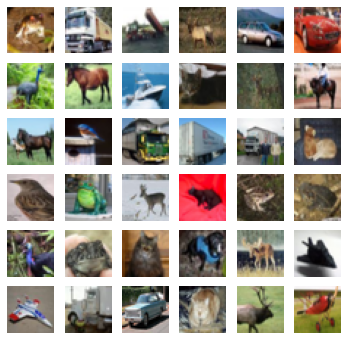

In [43]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


print(f"Train size: {trainset.data.shape}")
print(f"Validation size: {validationset.dataset.data.shape}")
print(f"Test size: {testset.dataset.data.shape}")

fig = plt.figure(figsize=(6, 6))

for i in range(36):
  plt.subplot(6, 6, i + 1)
  plt.imshow(trainset[i][0].numpy().transpose((1,2,0)))
  plt.axis('off')

plt.show()

# myCNN

**load dataset**

In [31]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 256 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
class myCNN(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            )
        self.fc = nn.Sequential(
            nn.Dropout(p=.5),
            nn.Linear(in_features=512*3*3, out_features=2048, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(in_features=2048, out_features=10, bias=True)   
            )


    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

**myCNN**: I implemented a simplified version of Alexnet to perform image classification. Instead of using 11x11 conv layer, I use 7x7 conv layer considering the size of cifar10 dataset. The entire structure will tranfer our image from 3 channels into 512 channels and downsample image from 32x32 to 3x3. There are total 4 conv layers and 3 maxpooling layers. Detailed network and corresponding image size are shown below using torchsummary. 

In [7]:
summary(myCNN().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           9,472
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 256, 12, 12]         409,856
              ReLU-5          [-1, 256, 12, 12]               0
         MaxPool2d-6            [-1, 256, 6, 6]               0
            Conv2d-7            [-1, 512, 6, 6]       1,180,160
              ReLU-8            [-1, 512, 6, 6]               0
            Conv2d-9            [-1, 512, 6, 6]       2,359,808
             ReLU-10            [-1, 512, 6, 6]               0
        MaxPool2d-11            [-1, 512, 3, 3]               0
          Dropout-12                 [-1, 4608]               0
           Linear-13                 [-1, 2048]       9,439,232
             ReLU-14                 [-

In [8]:
model = Net(myCNN(), lr = 0.01)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    logger=CSVLogger(save_dir="myCNNlogs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | myCNN    | 13.4 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


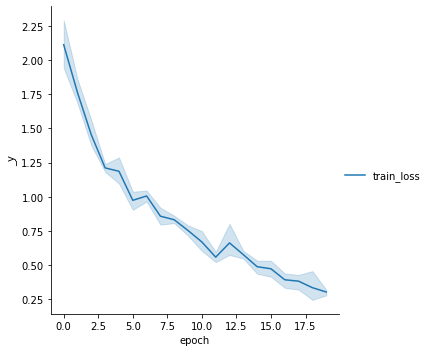

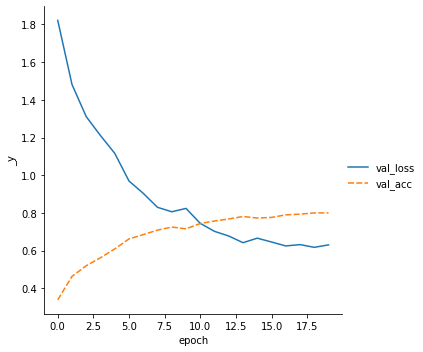

In [9]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [10]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7996000051498413
        test_loss           0.6188925504684448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6188925504684448, 'test_acc': 0.7996000051498413}]

# Resnet


In [20]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 256 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**Resnet50**: I decided to use resnet50 in this part of assignment. Compared to myCNN, Resnet50 doesn't utilize various size of conv kernel. It use a combination of 3x3 kernel within each layer. Addtionally, resnet50 used resblock/bottleneck where each 2xconv/3xconv output will combine an identity layer to pervent learning degredation. Each conv layer will follow with a batchnorm + relu to avoid gradient vanishing/exploding. 

In [21]:
resnet50 = torchvision.models.resnet50(pretrained = True)
resnet50.conv1 = nn.Conv2d(3, 64, kernel_size = 3, padding=1, bias=False)
resnet50.maxpool = nn.Sequential()
resnet50.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=1000, bias=True),
    nn.Linear(in_features=1000, out_features=10, bias=True)
)

summary(resnet50.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

In [22]:
model = Net(resnet50, lr = 0.0001)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    logger=CSVLogger(save_dir="myCNNlogs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | ResNet   | 25.6 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.237   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


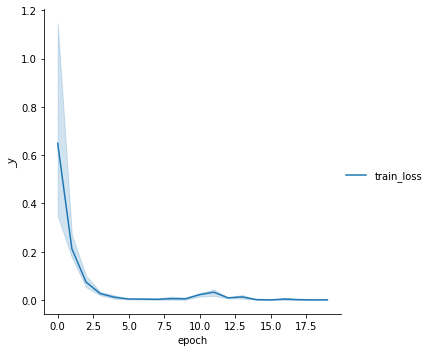

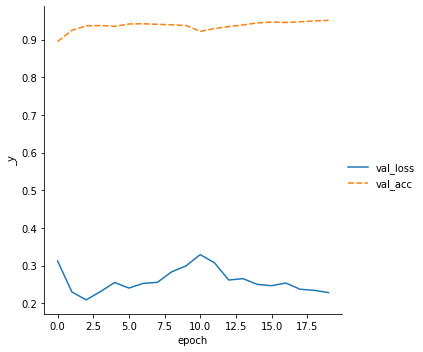

In [23]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [24]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9394000172615051
        test_loss            0.275981068611145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.275981068611145, 'test_acc': 0.9394000172615051}]

Result shows that testing accuracy could be improved dramatically compared with myCNN. Deeper network + pre-trained model contribute mostly to this improvement. 

# AutoAugment Data

**Augmentation**: I use autoaugmentation which is a RL method exploring the most effective way to perturb image data that could achieve the best testing improvement. There are overall 24 policies generated (two pertubation as a pair) and will randomly apply one of them to the image. 


Cite: https://arxiv.org/pdf/1805.09501.pdf

In [11]:
transform_train = transforms.Compose(
    [   transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

batch = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

validationset, testset = torch.utils.data.random_split(testset, [len(testset)//2,len(testset)-len(testset)//2])


valloader = torch.utils.data.DataLoader(validationset, batch_size=batch,
                                         shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
model = Net(myCNN(), lr = 1e-2)
trainer = pl.Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    logger=CSVLogger(save_dir="myCNNlogs/"),
)

trainer.fit(model, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type     | Params
--------------------------------------------
0 | net            | myCNN    | 13.4 M
1 | train_accuracy | Accuracy | 0     
2 | val_accuracy   | Accuracy | 0     
3 | test_accuracy  | Accuracy | 0     
--------------------------------------------
13.4 M    Trainable params
0         Non-trainable params
13.4 M    Total params
53.676    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


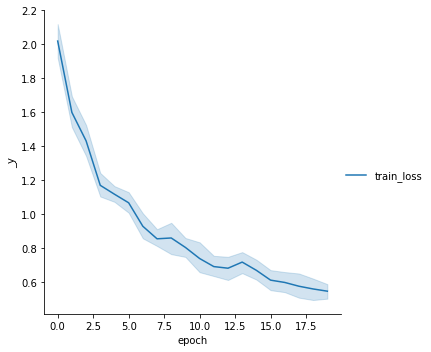

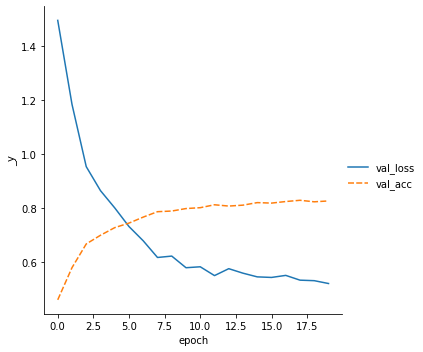

In [13]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
#display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[["train_loss"]], kind="line")
sn.relplot(data=metrics[["val_loss", "val_acc"]], kind="line")

In [14]:
trainer.test(model, testloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8212000131607056
        test_loss           0.5197190642356873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5197190642356873, 'test_acc': 0.8212000131607056}]

**Analysis**: Result shows that testing accuracy will improve about 1% with image augmentation. Since each batch of images are randomly perturbed, it will be more difficult for our model to overfit. This process will force our model to learn the true characteristic of an image. Therefore, our model will be more capable to generalize. 

# Variational Autoencoder (VAE):

I follow the below instruction to implement a VAE


Cite: https://www.tensorflow.org/tutorials/generative/cvae

In [15]:
train_size = 50000 
batch_size = 128
test_size = 10000

epochs = 100
latent_dim = 1024
num_examples_to_generate = 36


In [16]:
(train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
  images = images.reshape((images.shape[0], 32, 32, 3)) / 255.
  return images.astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

170498071/170498071 [==============================] - 2s 0us/step


In [17]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(1, 1), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(1, 1), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=512, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*512, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 512)),
            tf.keras.layers.Conv2DTranspose(
                  filters=512, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                  filters=256, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                  filters=128, kernel_size=3, strides=2, padding='same',
                  activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=1, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=1, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def call(self, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)

In [18]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(0.7 * logpx_z +  0.3*(logpz -logqz_x) )


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
    plt.subplot(6, 6, i + 1)
    #print(predictions[0].shape)
    plt.imshow(predictions[i])
    plt.axis('off')

  plt.show()

In [19]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [20]:
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
model.build((batch_size,32, 32, 3))
model.summary()

Model: "cvae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2048)              5764928   
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         12324675  
                                                                 
Total params: 18,089,603
Trainable params: 18,089,603
Non-trainable params: 0
_________________________________________________________________


Epoch: 100, Test set ELBO: -1273.8316650390625


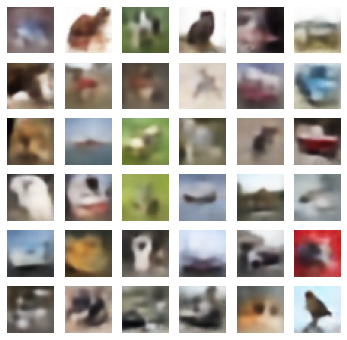

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-03, decay=1e-5)

generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}'.format(epoch, elbo))
  generate_and_save_images(model, epoch, test_sample)


# Generative Adversarial Networks (GANs)

I follow the instruction using below link. 

Reference: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [22]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils import plot_model
from matplotlib import pyplot

**Discriminator**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 256)        

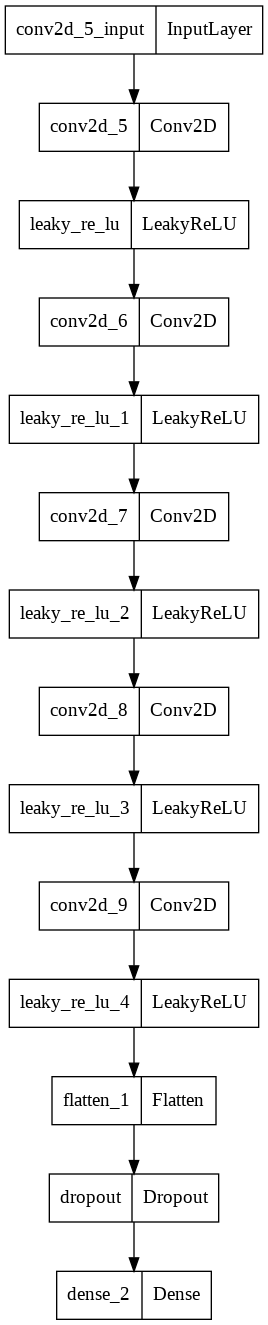

In [23]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, (3,3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

testmodel = define_discriminator()

testmodel.summary()
plot_model(testmodel)

**Generator**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              827392    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 16, 16, 128)      524416    
 ranspose)                                            

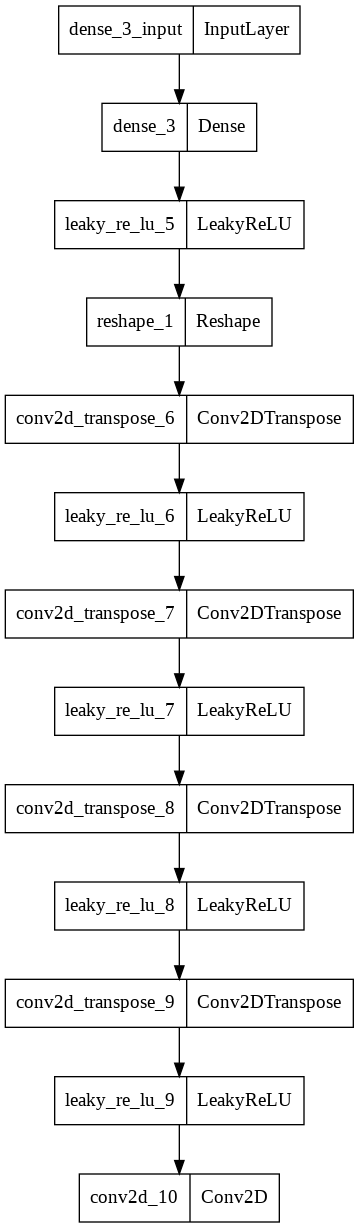

In [24]:
def define_generator(latent_dim):
    model = Sequential()

    n_nodes = 512 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 512)))

    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128, (4,4), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


testmodel = define_generator(100)

testmodel.summary()
plot_model(testmodel)

**Define GAN**

In [25]:
def define_gan(g_model, d_model):
  
    d_model.trainable = False

    model = Sequential()
    model.add(g_model)
    model.add(d_model)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [26]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = trainX.astype('float32')
    X = (X - 127.5) / 127.5
    return X
 
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 

def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input, verbose = 0)
    y = zeros((n_samples, 1))
    return X, y
 
def plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  fig = pyplot.figure(figsize=(8, 8))
  for i in range(n * n):
      pyplot.subplot(n, n, 1 + i)
      pyplot.axis('off')
      pyplot.imshow(examples[i])
  pyplot.show()


def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):

    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    plot(x_fake, epoch)

In [27]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        
        for j in range(bat_per_epo):

            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            #if j % 100 == 0:
              #print(f"Epoch: {i+1}, d1: {d_loss1}, d2: {d_loss2}, g: {g_loss}")
        display.clear_output(wait=False)
        summarize_performance(i, g_model, d_model, dataset, latent_dim)



>Accuracy real: 81%, fake: 87%


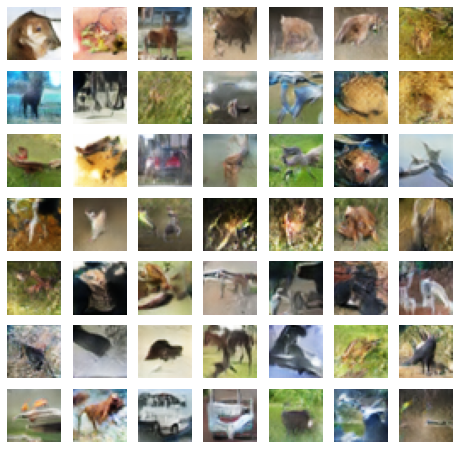

In [28]:

latent_dim = 1024

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)